# Homework 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## Problem 1
Let us assume a participant is performing a visuomotor rotation task.
There are $50$ baseline trials without rotation, then $50$ adaptation trials
with a $30^{\circ}$ rotation, followed by $8$ trials with a $-30$ degree
counter-rotation, and finally  $30$ error clamp trials (with no feedback).

In [2]:
p = np.concatenate([np.zeros(50), 30*np.ones(50), -30*np.ones(8), 30*np.zeros(30)])
clamp = np.concatenate([np.full(50, False), np.full(50, False), np.full(8, False), 30*np.full(30, True)])
num_trials = len(p)
t = np.arange(num_trials)+1



### a. No forgetting
Assume a single state model with only an adaptation rate ($B = 0.2$),
with output noise $\sigma_{\epsilon}=8$ and state noise $\sigma_{\eta}=1.5$.

Plot the adaptation and error curves.



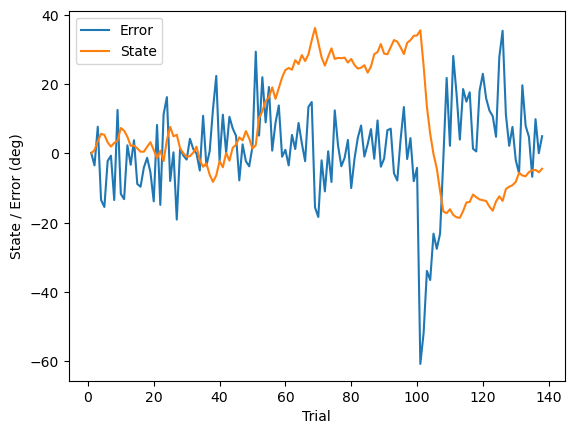

In [11]:
x = np.zeros_like(p)
y = np.zeros_like(p)
B = 0.2
s_epsilon = 8
s_eta = 1.5
epsilon = rng.normal(0, s_epsilon, num_trials)
eta = rng.normal(0, s_eta, num_trials)

for i in range(num_trials-1):
    y[i] = x[i] + p[i] + epsilon[i]
    x[i+1] = x[i] - B*y[i] + eta[i]
    if clamp[i]:
        x[i+1] = x[i] + eta[i]

y[num_trials-1] = x[num_trials-1] + p[num_trials-1] + epsilon[num_trials-1]

plt.figure()

plt.plot(t, y, label="Error")
plt.plot(t, -x, label="State")

plt.xlabel("Trial")
plt.ylabel("State / Error (deg)")
plt.legend()
plt.show()

### b. With forgetting
Now include a retention rate ($A = 0.98$; $B = 0.1$). Use the same noises

Plot the adaptation
and error curves.

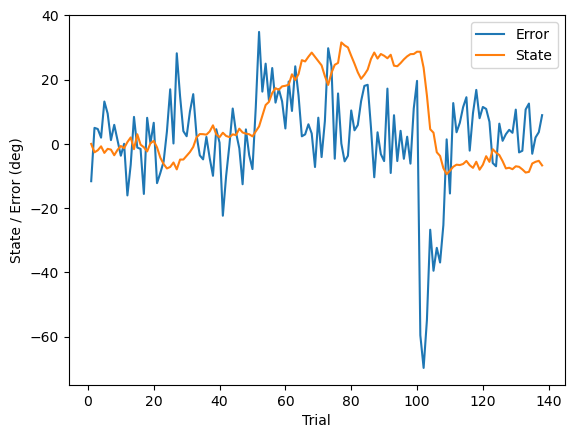

In [13]:
x = np.zeros_like(p)
y = np.zeros_like(p)
A = 0.98
B = 0.1
epsilon = rng.normal(0, s_epsilon, num_trials)
eta = rng.normal(0, s_eta, num_trials)


for i in range(num_trials-1):
    y[i] = x[i] + p[i] + epsilon[i]
    x[i+1] = A*x[i] - B*y[i] + eta[i]
    if clamp[i]:
        x[i+1] = A*x[i] + eta[i]

y[num_trials-1] = x[num_trials-1] + p[num_trials-1] + epsilon[num_trials-1]

plt.figure()

plt.plot(t, y, label="Error")
plt.plot(t, -x, label="State")

plt.xlabel("Trial")
plt.ylabel("State / Error (deg)")
plt.legend()
plt.show()

### c. Two state model
Turn this into a two state model. Use the same state noise for both states
and output noise as above.

\begin{equation}
A_f: 0.95 \\
A_s: 0.992 \\
B_f: 0.18 \\
B_s: 0.03
\end{equation}

Plot the adaptation and error curves.



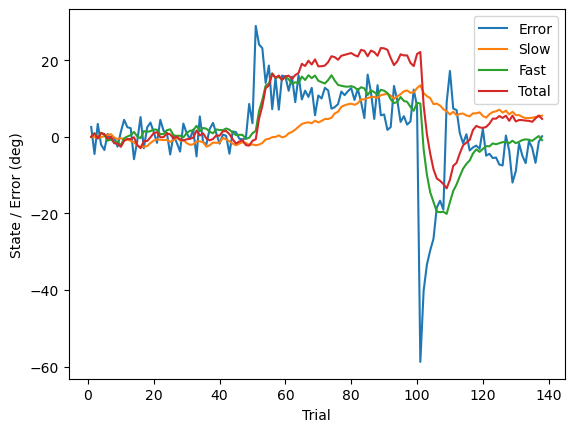

In [18]:
x_f = np.zeros_like(p)
x_s = np.zeros_like(p)
y = np.zeros_like(p)

A_f = 0.85
A_s = 0.999
B_f = 0.18
B_s = 0.03

s_epsilon = 3
s_eta = 0.5

epsilon = rng.normal(0, s_epsilon, num_trials)
eta_f = rng.normal(0, s_eta, num_trials)
eta_s = rng.normal(0, s_eta, num_trials)

for i in range(num_trials-1):
    y[i] = x_f[i] + x_s[i] + p[i] + epsilon[i]
    x_f[i+1] = A_f*x_f[i] - B_f*y[i] + eta_f[i]
    x_s[i+1] = A_s*x_s[i] - B_s*y[i] + eta_s[i]
    if clamp[i]:
        x_f[i+1] = A_f*x_f[i] + eta_f[i]
        x_s[i+1] = A_s*x_s[i] + eta_s[i]

y[num_trials-1] = x_f[num_trials-1] + x_s[num_trials-1] + p[num_trials-1] + epsilon[num_trials-1]

plt.figure()

plt.plot(t, y, label="Error")
plt.plot(t, -x_s, label="Slow")
plt.plot(t, -x_f, label="Fast")
plt.plot(t, -x_s-x_f, label="Total")

plt.xlabel("Trial")
plt.ylabel("State / Error (deg)")
plt.legend()
plt.show()

or curves.

## Problem 2

Download the paper (available as part of this assignment):

> Therrien AS, Wolpert DM, Bastian AJ. Effective reinforcement learning following cerebellar damage requires a balance between exploration and motor noise. Brain. 2016 Jan;139(Pt 1):101-14. doi: 10.1093/brain/awv329.

You may want to read the whole paper, but pay particular attention to the
methods for providing reward in the closed loop reinforcement (at the end
end of the methods for experiment 1, but note that we will actually
be simulating experiment 2) and to the section on the model
analysis (although you do not need the section on how they used
particle filters to do the fitting).

Implement the model they describe and reproduce the right hand plots in
figure 6A, 6B, and 6C using the parameters given.





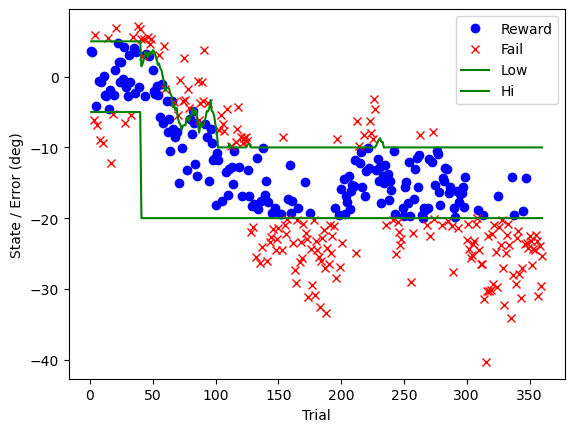

In [53]:
# Build gradual target shift
num_trials = 360

def set_lo(y, t):
    if t < 40:
        lo = -5
    else:
        lo = -20
    return lo

def set_hi(y, t):
    if t < 40:
        hi = 5
    else:
        yMean = np.mean(y[t-10:t-1])
        hi = np.max((yMean, -10))
    return hi
            

def simulate_adaptation(s_m, s_e):
    x = np.zeros(num_trials)
    y = np.zeros(num_trials)
    e = rng.normal(0, s_e, num_trials)
    m = rng.normal(0, s_m, num_trials)
    zone_lo = np.zeros(num_trials)
    zone_hi = np.zeros(num_trials)
    reward = np.full(num_trials, False)

    for t in range(num_trials):
        y[t] = x[t] + e[t] + m[t] 
        zone_lo[t] = set_lo(y, t)
        zone_hi[t] = set_hi(y, t)
        reward[t] = zone_lo[t] <= y[t] and y[t] <= zone_hi[t]
        if t < num_trials-1:
            x[t+1] = x[t] + reward[t]*e[t]
    
    return {
        "x": x, "y": y, "zone_lo": zone_lo, "zone_hi": zone_hi, "reward": reward
    }

trial_num = np.arange(1, num_trials+1)

cerebellar_s_m = 4
cerebellar_s_e = 1.58
cerebellar = simulate_adaptation(cerebellar_s_m, cerebellar_s_e)

def draw_learning(d):
    reward = d["reward"]
    y = d["y"]
    zone_lo = d["zone_lo"]
    zone_hi = d["zone_hi"]


    
    plt.figure()

    plt.plot(trial_num[reward], y[reward], 'bo', label="Reward")
    plt.plot(trial_num[~reward], y[~reward], 'rx', label="Fail")
    plt.plot(trial_num, zone_lo, 'g-', label="Low")
    plt.plot(trial_num, zone_hi, 'g-', label="Hi")


    plt.xlabel("Trial")
    plt.ylabel("State / Error (deg)")
    plt.legend()
    plt.show()
    
draw_learning(cerebellar)

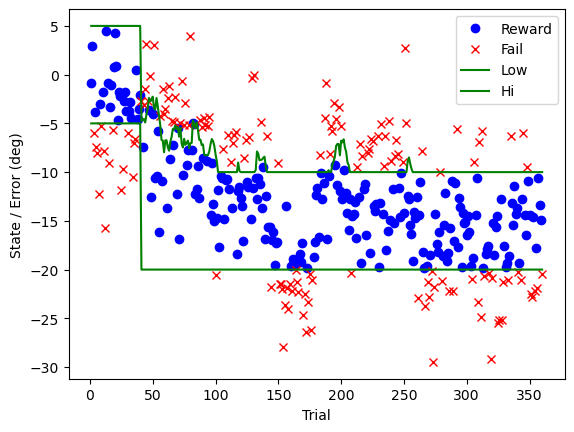

In [54]:
older_s_m = 4
older_s_e = 1.58
older = simulate_adaptation(older_s_m, older_s_e)
draw_learning(older)


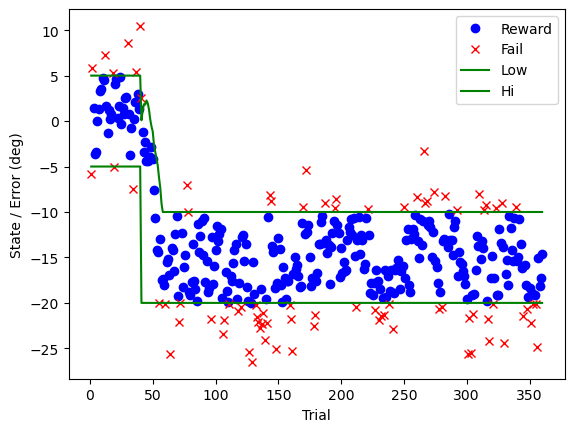

In [55]:
young_s_m = 0.36
young_s_e = 3.37
young = simulate_adaptation(young_s_m, young_s_e)
draw_learning(young)